In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
0.013*10

0.13

In [16]:
model = pybamm.lithium_ion.DFN(options={
    #"SEI": "constant",
    #"SEI porosity change": "true",
    #"SEI on cracks": "true",
    #"particle mechanics": "constant cracks",
    "contact resistance": "true",
})

param = pybamm.ParameterValues("OKane2023")

exp = pybamm.Experiment(
    [("Discharge at 2C for 300 seconds", )] * 1,
)

var_pts = {
    "x_n": 15,  # negative electrode
    "x_s": 16,  # separator 
    "x_p": 15,  # positive electrode
    "r_n": 60,  # negative particle
    "r_p": 30,  # positive particle
}

sim = pybamm.Simulation(model, parameter_values=param, experiment=exp, var_pts=var_pts)
sol = sim.solve()

In [25]:
mesh_sep = len(sol["Separator electrolyte potential [V]"].entries[:,0])
if mesh_sep % 2 ==0:
    phi_ref = (
        sol["Separator electrolyte potential [V]"].entries[mesh_sep//2-1,:]
        +
        sol["Separator electrolyte potential [V]"].entries[mesh_sep//2+1,:]
        ) / 2
    print(mesh_sep/2+0.5)
else:
    phi_ref = sol["Separator electrolyte potential [V]"].entries[mesh_sep//2,:]
    print(mesh_sep//2+1)
V =  sol["Terminal voltage [V]"].entries
V_n = -phi_ref                     # negative tab is 0 V
V_p = V - phi_ref                 # V = V_p - V_n
time = sol["Time [s]"].entries

8.5


In [17]:
mesh_sep = len(sol["Separator electrolyte potential [V]"].entries[:,0])
print(mesh_sep)
phi_ref = sol["Separator electrolyte potential [V]"].entries[8,:] # centre, assuming 5 point
V =  sol["Terminal voltage [V]"].entries
V_n = -phi_ref                     # negative tab is 0 V
V_p = V - phi_ref                 # V = V_p - V_n
time = sol["Time [s]"].entries

16


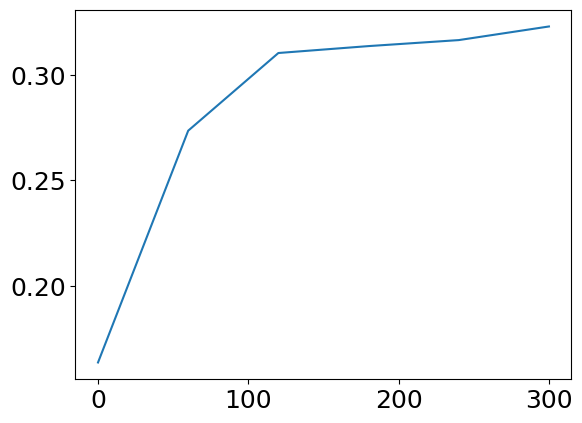

In [26]:
plt.plot(time,V_n)

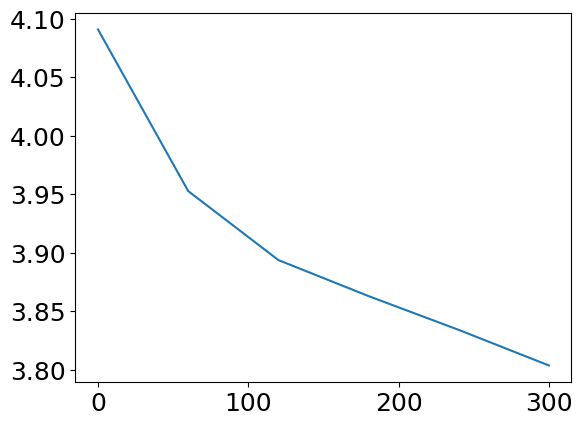

In [27]:
plt.plot(time,V_p)

In [12]:
import matplotlib as mpl; 
fs = 18
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

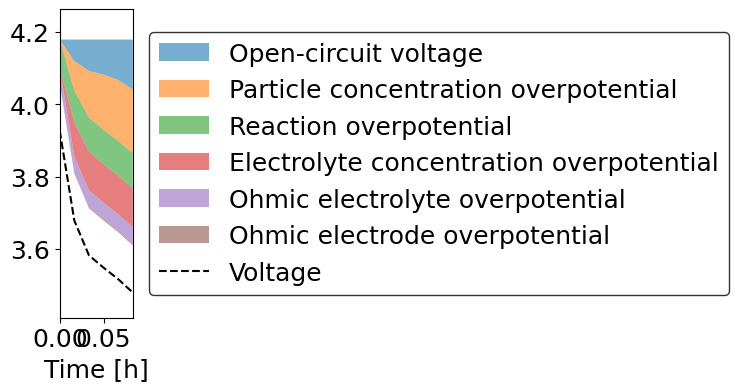

(<Figure size 800x400 with 1 Axes>, <Axes: xlabel='Time [h]'>)

In [13]:
pybamm.plot_voltage_components(sim.solution)

In [27]:
V_contact = bottom - V
print(V_contact)

[0.13000006 0.13000004 0.13000004 0.13000005 0.13000006 0.13000006]


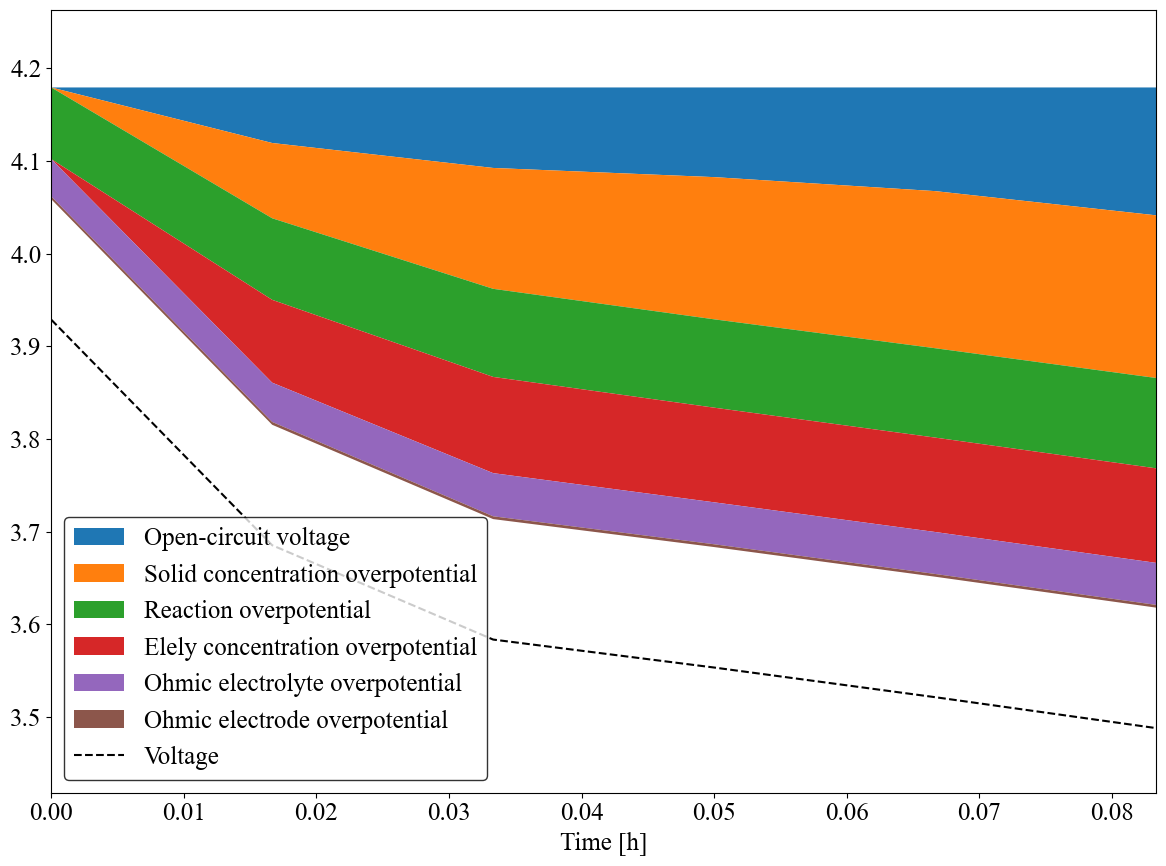

In [25]:
show_legend = True
fig, ax = plt.subplots(figsize=(12,9),tight_layout=True)
overpotentials = [
    "Battery particle concentration overpotential [V]",
    "X-averaged battery reaction overpotential [V]",
    "X-averaged battery concentration overpotential [V]",
    "X-averaged battery electrolyte ohmic losses [V]",
    "X-averaged battery solid phase ohmic losses [V]",
]
labels = [
    "Solid concentration overpotential",
    "Reaction overpotential",
    #"Concentration overpotential - EC",
    "Elely concentration overpotential",
    "Ohmic electrolyte overpotential",
    "Ohmic electrode overpotential",
]

# Plot
# Initialise
solution = sol
time = solution["Time [h]"].entries # 
initial_ocv = solution['Battery open-circuit voltage [V]'].entries[0]
ocv = solution['Battery open-circuit voltage [V]'].entries
ax.fill_between(time, ocv, initial_ocv,  label="Open-circuit voltage")
top = ocv
# Plot components
for overpotential, label in zip(overpotentials, labels):
    if overpotential == "Contact overpotential [V]":
        bottom = top - solution[overpotential].entries
    else:
        bottom = top + solution[overpotential].entries
    ax.fill_between(time, bottom, top,   label=label)
    top = bottom

V = solution["Terminal voltage [V]"].entries
ax.plot(time, V, "k--", label="Voltage")

if show_legend:
    leg = ax.legend(loc="lower left", frameon=True)
    leg.get_frame().set_edgecolor("k")

# Labels
ax.set_xlim([time[0], time[-1]])
ax.set_xlabel("Time [h]")

y_min, y_max = 0.98 * min(np.nanmin(V), np.nanmin(ocv)), 1.02 * (
    max(np.nanmax(V), np.nanmax(ocv))
)
ax.set_ylim([y_min, y_max])
plt.show()

Text(0.5, 1.0, 'Potential error')

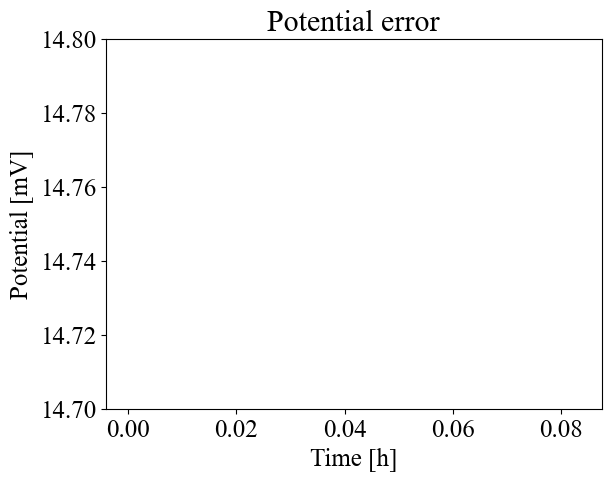

In [26]:
plt.plot(time, (bottom-V)*1e3, "r-", label="Voltage")
plt.ylabel("Potential [mV]",   fontdict={'family':'Times New Roman','size':fs})
plt.xlabel('Time [h]',   fontdict={'family':'Times New Roman','size':fs})
plt.ylim(1.47e1,1.48e1)
plt.title("Potential error")